In [59]:
import pandas as pd
df = pd.read_csv("padchest_labels.csv", usecols=["ImageID","PatientID","Projection", "Labels"])

In [60]:
# Drop the rows where the Projection is not PA or AP
df = df[df["Projection"].isin(["PA", "AP", "AP_horizontal"])]
# count the number of rows
print(f"Starting count: {len(df)}")
# check for NA values
print(df.isna().sum())
# drop the rows with NA values
df = df.dropna()
# count the number of rows
print(f"No NA count: {len(df)}")
# each label is a string of a list, iterate through the rows and replace the format from "['a', 'b', 'c']" to "a|b|c"
for index, row in df.iterrows():
    labels = row["Labels"]
    labels = labels.replace("[","").replace("]","").replace("'","").replace(", ","|").replace(" ","")
    df.at[index, "Labels"] = labels


Starting count: 110633
ImageID        0
PatientID      0
Projection     0
Labels        79
dtype: int64
No NA count: 110554


In [61]:
labels = df["Labels"].str.get_dummies(sep="|")
df = pd.concat([df, labels], axis=1)
df.drop(columns=["Labels"], inplace=True)
df.columns = df.columns.str.capitalize()

In [62]:
# merge all columns that contain "atelectasis" into one column, whose value is 1 if any of the columns contain 1
# and 0 otherwise, then drop the original columns
at_aliases = [i for i in df.columns if "atelectasis" in i.lower()]
df["Atelectasis"] = df[at_aliases].max(axis=1)
at_aliases.remove("Atelectasis")
df.drop(columns=at_aliases, inplace=True)
# do the same for "effusion"
eff_aliases = [i for i in df.columns if "effusion" in i.lower()]
df["Effusion"] = df[eff_aliases].max(axis=1)
df.drop(columns=eff_aliases, inplace=True)
# do the same for "pneumonia"
pne_aliases = [i for i in df.columns if "pneumonia" in i.lower()]
df["Pneumonia"] = df[pne_aliases].max(axis=1)
pne_aliases.remove("Pneumonia")
df.drop(columns=pne_aliases, inplace=True)
# do the same for "pneumothorax"
pneu_aliases = [i for i in df.columns if "pneumothorax" in i.lower()]
df["Pneumothorax"] = df[pneu_aliases].max(axis=1)
pneu_aliases.remove("Pneumothorax")
df.drop(columns=pneu_aliases, inplace=True)

In [63]:
common_diseases = [
    "Atelectasis",
    "Cardiomegaly",
    "Consolidation",
    "Edema",
    "Effusion",
    "No Finding",
    "Pneumonia",
    "Pneumothorax"
]

# Capitalize the first letter of the label, replace pulmonary edema with Edema, replace normal with No Finding
df.rename(columns={"Pulmonaryedema":"Edema", "Normal":"No Finding"}, inplace=True)

# find if the common diseases are present as column names in the dataframe
for disease in common_diseases:
    if disease not in df.columns:
        print(f"{disease} not found")
    else:
        print(f"{disease} found")

Atelectasis found
Cardiomegaly found
Consolidation found
Edema found
Effusion found
No Finding found
Pneumonia found
Pneumothorax found


In [64]:
# go through the dataframe and drop rows where there are no 1s for any common diseases 
df_2 = df.loc[(df[common_diseases] != 0).any(axis=1)]
cnt = df.shape[0] - df.loc[(df[common_diseases] != 0).any(axis=1)].shape[0]
print(f"Dropped {cnt} rows from the dataset.")  


Dropped 48961 rows from the dataset.


In [ ]:
# drop any column past 3 whose name is not in common_diseases
for col in df_2.columns[3:].tolist():
    if col not in common_diseases:
        df_2.drop(columns=col, inplace=True)   
# rearrange the disease columns so that they are in the same order as common_diseases 
cols = list(df_2.columns[:3]) + common_diseases
df_2 = df_2[cols] 

In [66]:
# find duplicate rows, which are those where the Patientid, the projection and the labels are the same
# mark the last duplicates and remove them
cnt_before = len(df_2)
df_2.drop_duplicates(subset=["Patientid", "Projection", "Atelectasis", "Cardiomegaly", "Consolidation", "Edema", "Effusion", "No Finding", "Pneumonia", "Pneumothorax"], keep="first", inplace=True)
# count the duplicates
print(f"Dropped {cnt_before - len(df_2)} duplicates.")


Dropped 10579 duplicates.


In [67]:
diseases = [
    "Atelectasis",
    "Cardiomegaly",
    "Consolidation",
    "Edema",
    "Effusion",
    "Pneumonia",
    "Pneumothorax"
]

In [68]:
# assert that No Finding is 1 if all other diseases are 0
assert (df_2[(df_2[diseases] == 0).all(axis=1)]["No Finding"] == 1).all()

<Axes: title={'center': 'Label distribution PC'}>

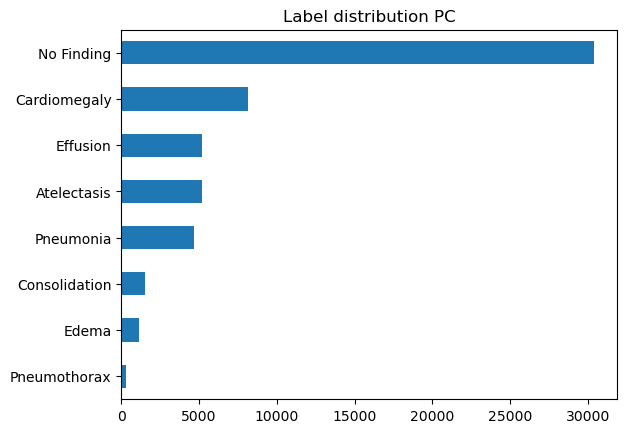

In [75]:
# label distribution of df_2
label_distribution = df_2[common_diseases].sum()
# plot as a horizontal bar chart, sorted
label_distribution.sort_values().plot(kind="barh", title="Label distribution PC")

In [76]:
# save the dataframe to a new csv file 
df_2.to_csv("padchest_processed.csv", index=False)

In [99]:
# Now let's preprocess the images to 224x224 and CLAHE and save them to a new folder
import cv2
import os
from tqdm import tqdm

# create a new folder to save the images
if not os.path.exists("images_224"):
    os.makedirs("images_224")

# iterate through the rows of the dataframe
df_pre = pd.read_csv("padchest_processed.csv")
for index, row in tqdm(df_pre.iterrows(), total=len(df_pre)):
    # get the image id
    image_id = row["Imageid"]
    # read the image
    img = cv2.imread(f"images/{image_id}", cv2.IMREAD_GRAYSCALE)
    # crop 5% of the image from all sides to remove blown borders and artifacts
    img = img[int(img.shape[0]*0.05):int(img.shape[0]*0.95), int(img.shape[1]*0.05):int(img.shape[1]*0.95)]
    # resize the image to 224x224
    img = cv2.resize(img, (224, 224))
    # # apply CLAHE
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    img = clahe.apply(img)
    # apply histogram equalization
    # img = cv2.equalizeHist(img)
    # save the image
    cv2.imwrite(f"images_224/{image_id}", img)

 86%|████████▋ | 44023/51014 [3:41:45<35:13,  3.31it/s]  


AttributeError: 'NoneType' object has no attribute 'shape'

In [108]:
index

44023

In [135]:
# Remove corrupted images
# 'images/216840111366964013076187734852011291090445391_00-196-188.png' is corrupted, skip it
df_pre = df_pre[df_pre["Imageid"] != "216840111366964013076187734852011291090445391_00-196-188.png"]
# same for 'images/216840111366964012373310883942009170084120009_00-097-074.png'
df_pre = df_pre[df_pre["Imageid"] != "216840111366964012373310883942009170084120009_00-097-074.png"]
# '216840111366964012373310883942009180082307973_00-097-011.png' is corrupted, skip it
df_pre = df_pre[df_pre["Imageid"] != "216840111366964012373310883942009180082307973_00-097-011.png"]
# '216840111366964012819207061112010281134410801_00-129-131.png' is corrupted, skip it
df_pre = df_pre[df_pre["Imageid"] != "216840111366964012819207061112010281134410801_00-129-131.png"]
# '216840111366964012989926673512011083134050913_00-168-009.png' is corrupted, skip it
df_pre = df_pre[df_pre["Imageid"] != "216840111366964012989926673512011083134050913_00-168-009.png"]
# "images/216840111366964012819207061112010306085429121_04-020-102.png" is corrupted, skip it
df_pre = df_pre[df_pre["Imageid"] != "216840111366964012819207061112010306085429121_04-020-102.png"]
#  'images/216840111366964012819207061112010307142602253_04-014-084.png' is corrupted, skip it
df_pre = df_pre[df_pre["Imageid"] != "216840111366964012819207061112010307142602253_04-014-084.png"]
# save the dataframe to a new csv file
df_pre.to_csv("padchest_processed.csv", index=False)

In [134]:
# continue the above from the last index

for index, row in tqdm(df_pre.iterrows(), total=len(df_pre)):
    if index > 50890:
        # get the image id
        image_id = row["Imageid"]
        # read the image
        img = cv2.imread(f"images/{image_id}", cv2.IMREAD_GRAYSCALE)
        # crop 5% of the image from all sides to remove blown borders and artifacts
        img = img[int(img.shape[0]*0.05):int(img.shape[0]*0.95), int(img.shape[1]*0.05):int(img.shape[1]*0.95)]
        # resize the image to 224x224
        img = cv2.resize(img, (224, 224))
        # # apply CLAHE
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        img = clahe.apply(img)
        # apply histogram equalization
        # img = cv2.equalizeHist(img)
        # save the image
        cv2.imwrite(f"images_224/{image_id}", img)

100%|██████████| 51014/51014 [00:36<00:00, 1382.36it/s] 


In [137]:
df_final = pd.read_csv("padchest_processed.csv")
# verify all the images are in the folder
for index, row in tqdm(df_final.iterrows(), total=len(df_final)):
    image_id = row["Imageid"]
    if not os.path.exists(f"images_224/{image_id}"):
        print(f"{image_id} not found")
        break

  0%|          | 0/51007 [00:00<?, ?it/s]

100%|██████████| 51007/51007 [01:29<00:00, 567.09it/s]  


In [138]:
# verify they are all valid image files
for index, row in tqdm(df_final.iterrows(), total=len(df_final)):
    image_id = row["Imageid"]
    img = cv2.imread(f"images_224/{image_id}", cv2.IMREAD_GRAYSCALE)
    if img is None:
        print(f"{image_id} is not a valid image")
        break

100%|██████████| 51007/51007 [04:08<00:00, 205.29it/s]


In [140]:
# rename Imageid to Path and convert labels to float
df_final.rename(columns={"Imageid":"Path"}, inplace=True)
df_final[common_diseases] = df_final[common_diseases].astype(float)

In [142]:
df_final.to_csv("padchest_processed.csv", index=False)

In [143]:
# keep 10k images for testing,
# making sure that the distribution of labels is the same
# as in the original dataset and images from test set patients are not in the training set
# first, find the unique patients
unique_patients = df_final["Patientid"].unique()
# shuffle the patients
import numpy as np
np.random.seed(42)
np.random.shuffle(unique_patients)
# keep enough patients to have 10k images



In [151]:
# take the first 8471 patients, check how many images they have
df_final[df_final["Patientid"].isin(unique_patients[:8471])].shape[0]

10000

In [ ]:
df_train_train

In [178]:
df_check = pd.read_csv("padchest_train.csv")

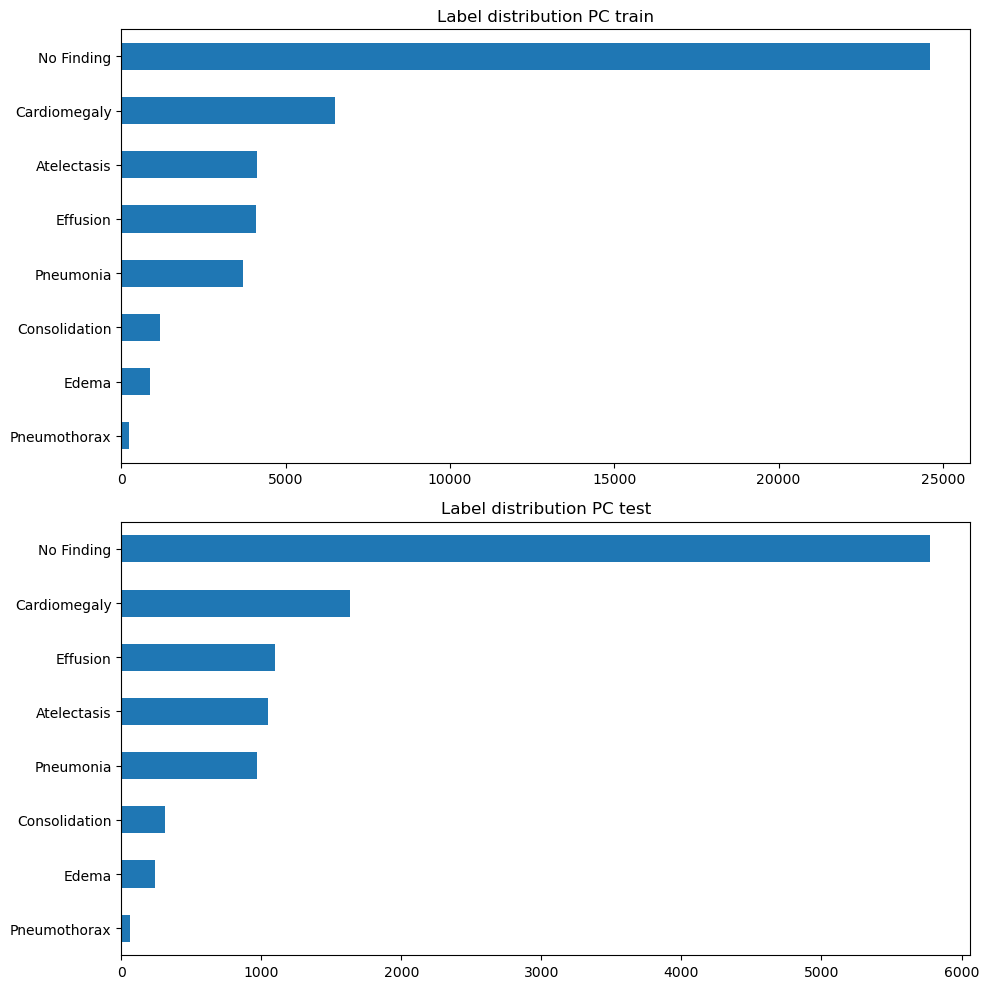

In [153]:
# make them the test set
df_test = df_final[df_final["Patientid"].isin(unique_patients[:8471])]
df_train = df_final[~df_final["Patientid"].isin(unique_patients[:8471])]
# plot the label distribution of df_train and df_test in a 2x1 grid
label_distribution_train = df_train[common_diseases].sum()
label_distribution_test = df_test[common_diseases].sum()
import matplotlib.pyplot as plt
fig, ax = plt.subplots(2, 1, figsize=(10, 10))
label_distribution_train.sort_values().plot(kind="barh", title="Label distribution PC train", ax=ax[0])
label_distribution_test.sort_values().plot(kind="barh", title="Label distribution PC test", ax=ax[1])
plt.tight_layout()
plt.show()

In [154]:
len(df_train), len(df_test)

(41007, 10000)

In [172]:
# keep 15k images for validation
# first, find the unique patients
unique_patients = df_train["Patientid"].unique()
# shuffle the patients again
np.random.seed(42)
np.random.shuffle(unique_patients)
# take the first 12920 patients, check how many images they have
df_train[df_train["Patientid"].isin(unique_patients[:12920])].shape[0]

# make them the validation set
df_val = df_train[df_train["Patientid"].isin(unique_patients[:12920])]
df_train_train = df_train[~df_train["Patientid"].isin(unique_patients[:12920])]

In [173]:
len(df_train_train), len(df_val), len(df_test)

(26007, 15000, 10000)

In [176]:
# save the train and test sets to csv files
df_train_train.to_csv("padchest_train.csv", index=False)
df_val.to_csv("padchest_val.csv", index=False)
df_test.to_csv("padchest_test.csv", index=False)

In [87]:
# load up the first image and compare histogram equalization and CLAHE using albumentations
import cv2
import numpy as np
import matplotlib.pyplot as plt
import albumentations as A
import random
# create a function to display the image
def display_image(image):
    plt.imshow(image)
    plt.axis("off")
    plt.show()
# create a function to display the histogram
def display_histogram(image):
    plt.hist(image.ravel(), 256, [0, 256])
    plt.show()

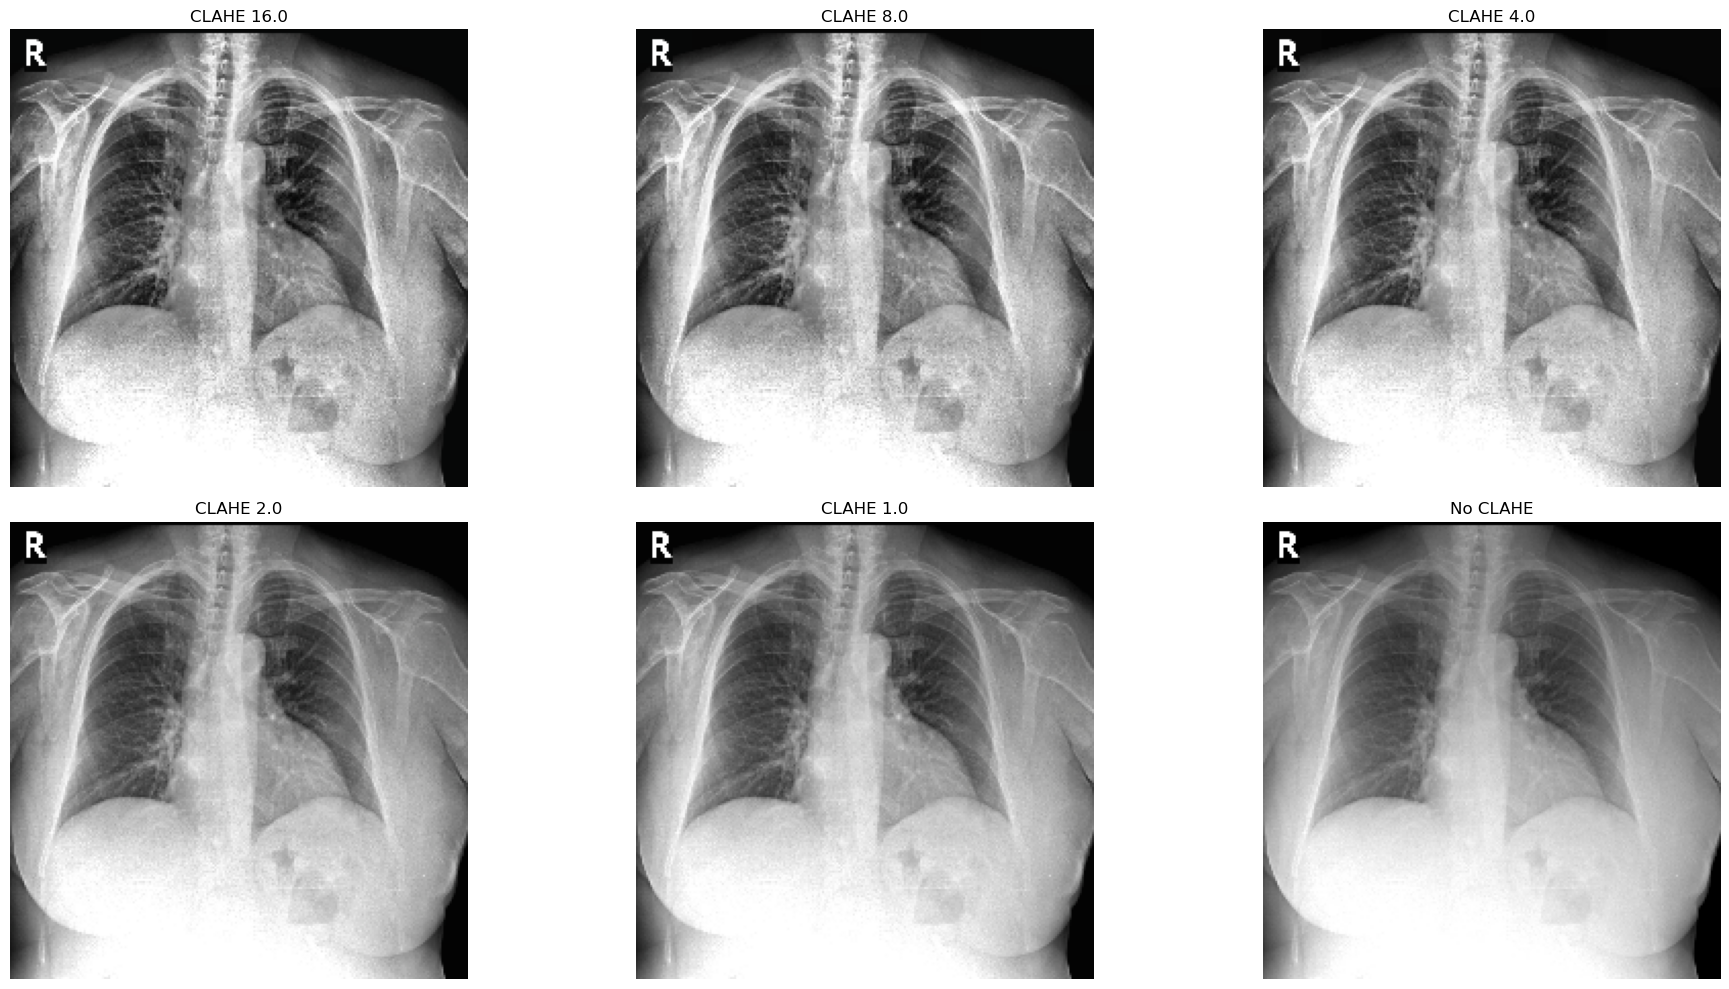

In [91]:
# load a random image from df_2['Imageid]
image_paths = df_2['Imageid'].tolist()
image_path = random.choice(image_paths)
image = cv2.imread(f'images/{image_path}')
# test different clip limits for CLAHE
tf = A.Compose([A.Resize(224, 224),
    A.CLAHE(clip_limit=16.0, tile_grid_size=(8, 8), always_apply=True)])
tf2 = A.Compose([A.Resize(224, 224),
    A.CLAHE(clip_limit=8.0, tile_grid_size=(8, 8), always_apply=True)])
tf3 = A.Compose([A.Resize(224, 224),
    A.CLAHE(clip_limit=4.0, tile_grid_size=(8, 8), always_apply=True)])
clahe_augmented_16 = tf(image=image)["image"]
clahe_augmented_8 = tf2(image=image)["image"]
clahe_augmented_4 = tf3(image=image)["image"]
tf4 = A.Compose([A.Resize(224, 224),
    A.CLAHE(clip_limit=2.0, tile_grid_size=(8, 8), always_apply=True)])
tf5 = A.Compose([A.Resize(224, 224),
    A.CLAHE(clip_limit=1.0, tile_grid_size=(8, 8), always_apply=True)])
tf6 = A.Compose([A.Resize(224, 224)])
clahe_augmented_2 = tf4(image=image)["image"]
clahe_augmented_1 = tf5(image=image)["image"]
clahe_augmented_no = tf6(image=image)["image"]

# display the original image and the histogram to the left in a 2x1 grid, then the transformations and their histograms in a 2x2 grid to the right
fig, axes = plt.subplots(2, 3, figsize=(20, 10))
axes[0, 0].imshow(clahe_augmented_16)
axes[0, 0].set_title("CLAHE 16.0")
axes[0, 0].axis("off")
axes[0, 1].imshow(clahe_augmented_8)
axes[0, 1].set_title("CLAHE 8.0")
axes[0, 1].axis("off")
axes[0, 2].imshow(clahe_augmented_4)
axes[0, 2].set_title("CLAHE 4.0")
axes[0, 2].axis("off")
axes[1, 0].imshow(clahe_augmented_2)
axes[1, 0].set_title("CLAHE 2.0")
axes[1, 0].axis("off")
axes[1, 1].imshow(clahe_augmented_1)
axes[1, 1].set_title("CLAHE 1.0")
axes[1, 1].axis("off")
axes[1, 2].imshow(clahe_augmented_no)
axes[1, 2].set_title("No CLAHE")
axes[1, 2].axis("off")

# missing the equalize augmented image and histogram
fig.tight_layout()

plt.show()


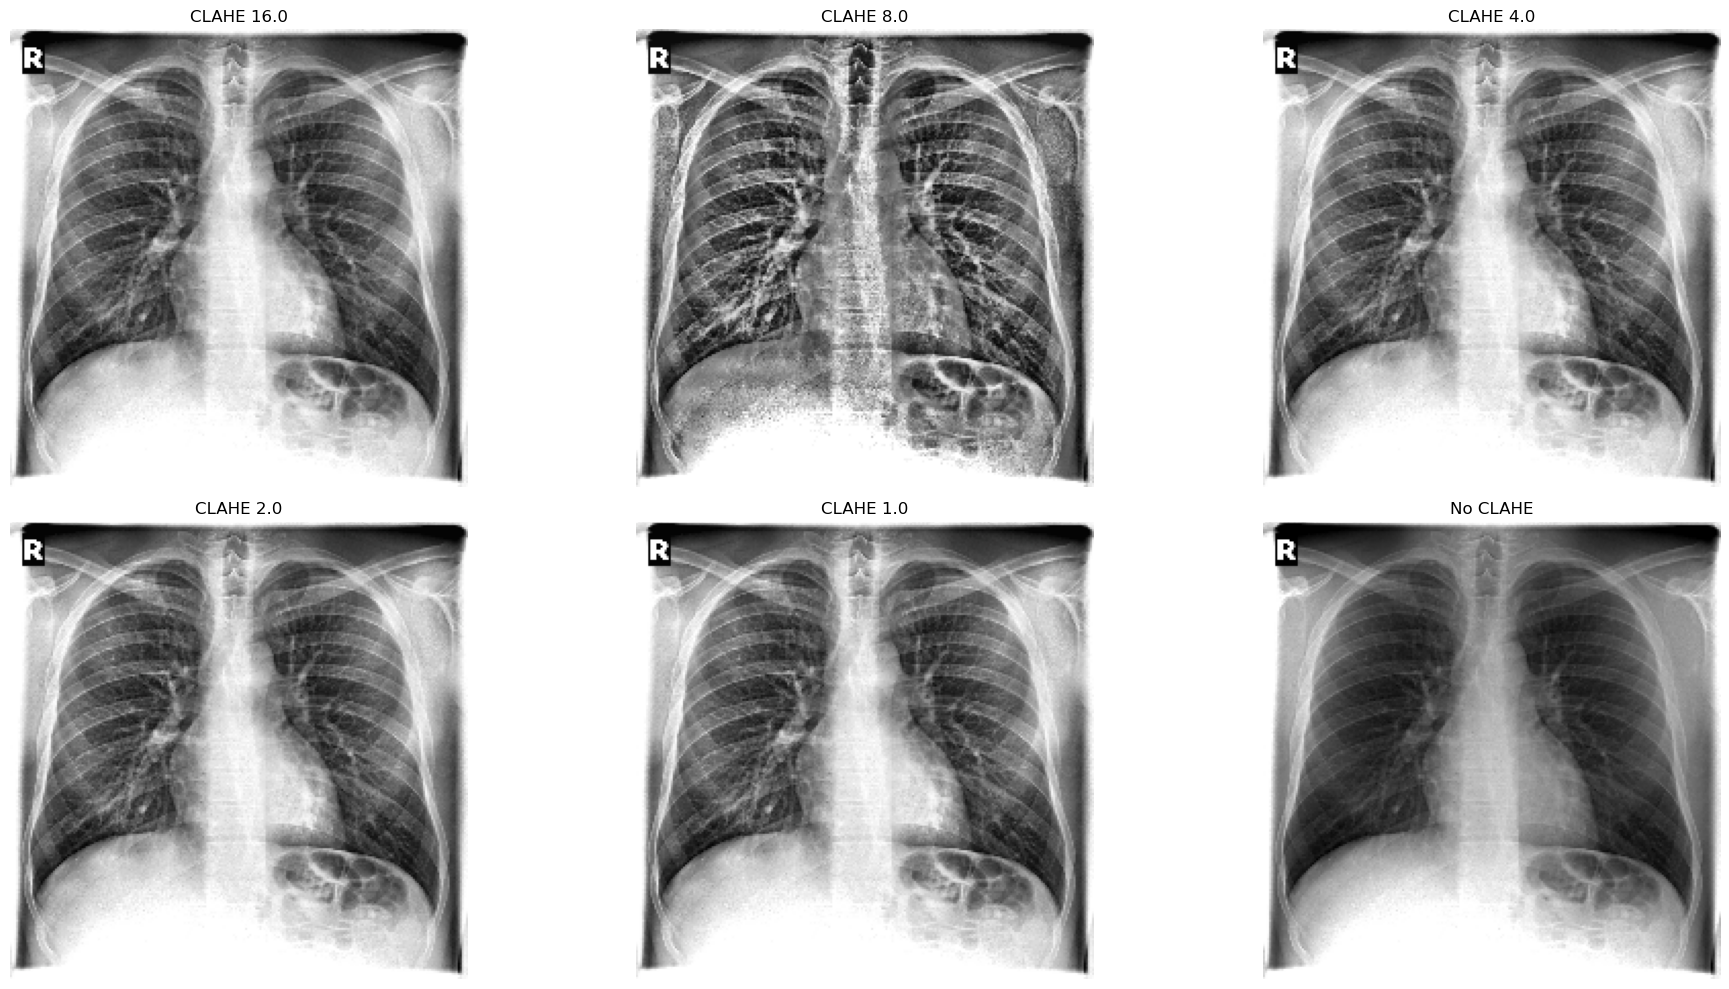

In [92]:
# do the same with a grid size of 16x16
# load a random image from df_2['Imageid]
image_paths = df_2['Imageid'].tolist()
image_path = random.choice(image_paths)
image = cv2.imread(f'images/{image_path}')
# test different clip limits for CLAHE
tf = A.Compose([A.Resize(224, 224),
    A.CLAHE(clip_limit=16.0, tile_grid_size=(16, 16), always_apply=True)])
tf2 = A.Compose([A.Resize(224, 224),
    A.CLAHE(clip_limit=8.0, tile_grid_size=(16, 16), always_apply=True)])
tf3 = A.Compose([A.Resize(224, 224),
    A.CLAHE(clip_limit=4.0, tile_grid_size=(16, 16), always_apply=True)])
clahe_augmented_16 = tf(image=image)["image"]
clahe_augmented_8 = tf2(image=image)["image"]
clahe_augmented_4 = tf3(image=image)["image"]
tf4 = A.Compose([A.Resize(224, 224),
    A.CLAHE(clip_limit=2.0, tile_grid_size=(16, 16), always_apply=True)])
tf5 = A.Compose([A.Resize(224, 224),
    A.CLAHE(clip_limit=1.0, tile_grid_size=(16, 16), always_apply=True)])
tf6 = A.Compose([A.Resize(224, 224)])
clahe_augmented_2 = tf4(image=image)["image"]
clahe_augmented_1 = tf5(image=image)["image"]
clahe_augmented_no = tf6(image=image)["image"]

# display the original image and the histogram to the left in a 2x1 grid, then the transformations and their histograms in a 2x2 grid to the right
fig, axes = plt.subplots(2, 3, figsize=(20, 10))
axes[0, 0].imshow(clahe_augmented_16)
axes[0, 0].set_title("CLAHE 16.0")
axes[0, 0].axis("off")
axes[0, 1].imshow(clahe_augmented_8)
axes[0, 1].set_title("CLAHE 8.0")
axes[0, 1].axis("off")
axes[0, 2].imshow(clahe_augmented_4)
axes[0, 2].set_title("CLAHE 4.0")
axes[0, 2].axis("off")
axes[1, 0].imshow(clahe_augmented_2)
axes[1, 0].set_title("CLAHE 2.0")
axes[1, 0].axis("off")
axes[1, 1].imshow(clahe_augmented_1)
axes[1, 1].set_title("CLAHE 1.0")
axes[1, 1].axis("off")
axes[1, 2].imshow(clahe_augmented_no)
axes[1, 2].set_title("No CLAHE")
axes[1, 2].axis("off")

# missing the equalize augmented image and histogram
fig.tight_layout()

plt.show()


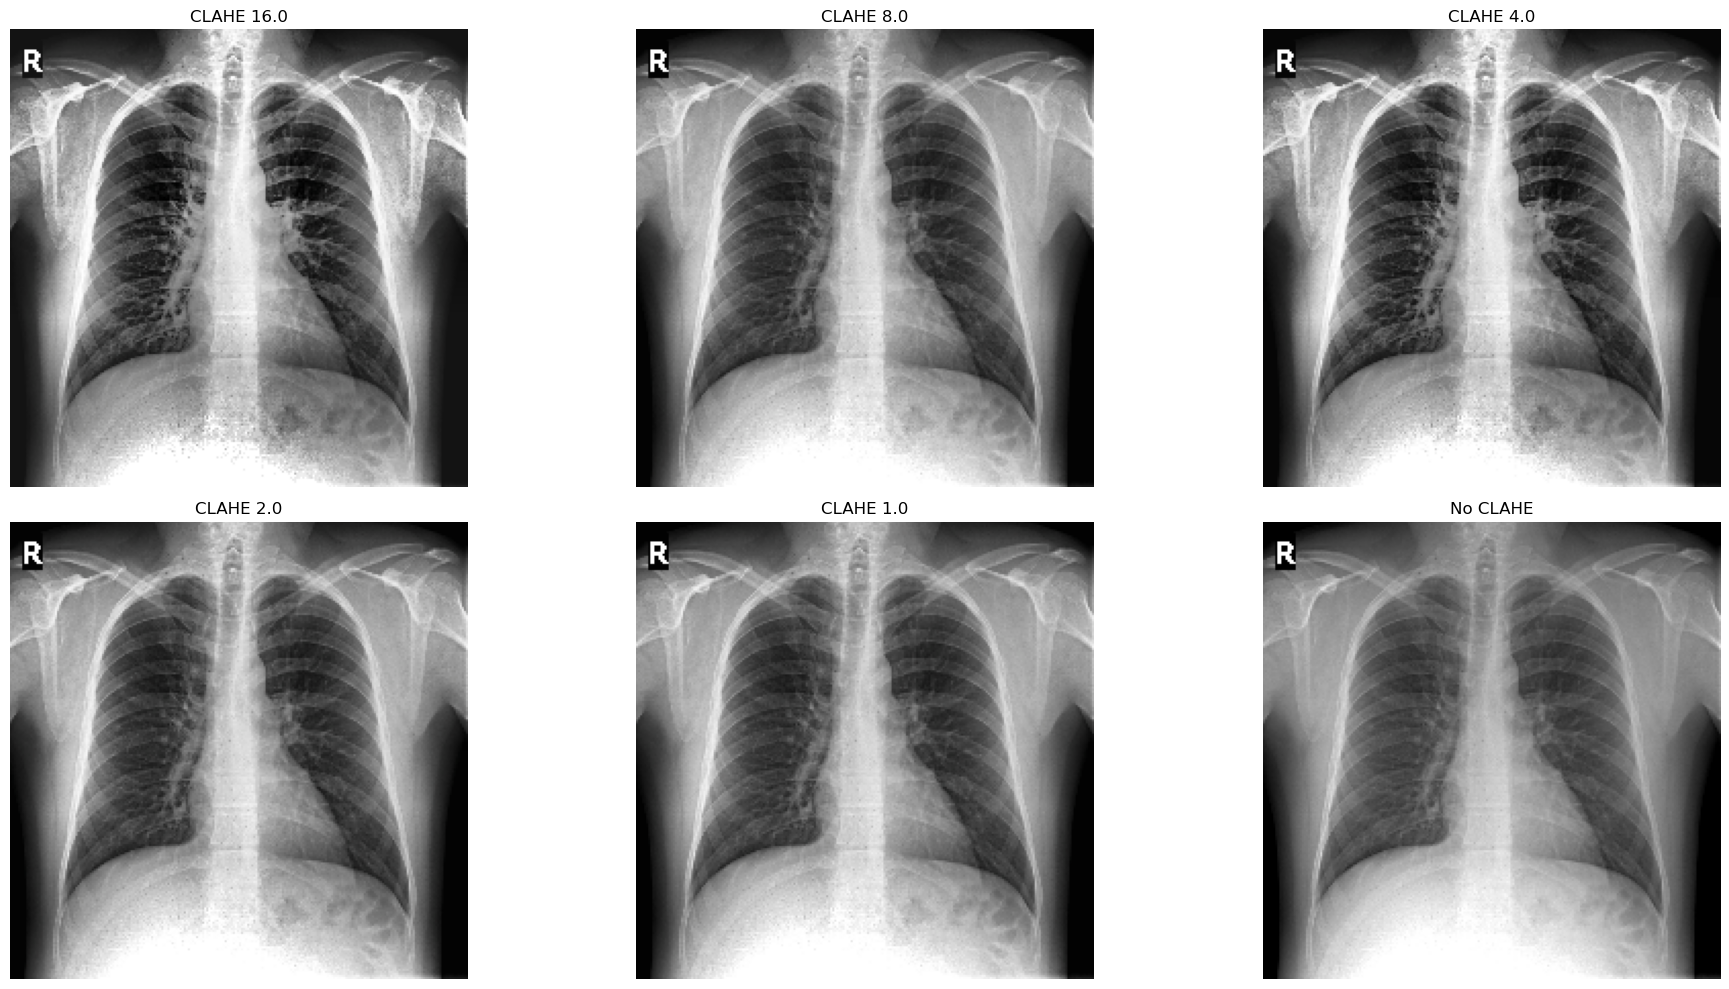

In [93]:
# load a random image from df_2['Imageid]
image_paths = df_2['Imageid'].tolist()
image_path = random.choice(image_paths)
image = cv2.imread(f'images/{image_path}')
# test different clip limits for CLAHE
tf = A.Compose([A.Resize(224, 224),
    A.CLAHE(clip_limit=16.0, tile_grid_size=(4, 4), always_apply=True)])
tf2 = A.Compose([A.Resize(224, 224),
    A.CLAHE(clip_limit=8.0, tile_grid_size=(4, 4), always_apply=True)])
tf3 = A.Compose([A.Resize(224, 224),
    A.CLAHE(clip_limit=4.0, tile_grid_size=(4, 4), always_apply=True)])
clahe_augmented_16 = tf(image=image)["image"]
clahe_augmented_8 = tf2(image=image)["image"]
clahe_augmented_4 = tf3(image=image)["image"]
tf4 = A.Compose([A.Resize(224, 224),
    A.CLAHE(clip_limit=2.0, tile_grid_size=(4, 4), always_apply=True)])
tf5 = A.Compose([A.Resize(224, 224),
    A.CLAHE(clip_limit=1.0, tile_grid_size=(4, 4), always_apply=True)])
tf6 = A.Compose([A.Resize(224, 224)])
clahe_augmented_2 = tf4(image=image)["image"]
clahe_augmented_1 = tf5(image=image)["image"]
clahe_augmented_no = tf6(image=image)["image"]

# display the original image and the histogram to the left in a 2x1 grid, then the transformations and their histograms in a 2x2 grid to the right
fig, axes = plt.subplots(2, 3, figsize=(20, 10))
axes[0, 0].imshow(clahe_augmented_16)
axes[0, 0].set_title("CLAHE 16.0")
axes[0, 0].axis("off")
axes[0, 1].imshow(clahe_augmented_8)
axes[0, 1].set_title("CLAHE 8.0")
axes[0, 1].axis("off")
axes[0, 2].imshow(clahe_augmented_4)
axes[0, 2].set_title("CLAHE 4.0")
axes[0, 2].axis("off")
axes[1, 0].imshow(clahe_augmented_2)
axes[1, 0].set_title("CLAHE 2.0")
axes[1, 0].axis("off")
axes[1, 1].imshow(clahe_augmented_1)
axes[1, 1].set_title("CLAHE 1.0")
axes[1, 1].axis("off")
axes[1, 2].imshow(clahe_augmented_no)
axes[1, 2].set_title("No CLAHE")
axes[1, 2].axis("off")

# missing the equalize augmented image and histogram
fig.tight_layout()

plt.show()
